In [ ]:
import shutil
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")


In [19]:
# Install Kaggle API
!pip install -q kaggle

# Upload Kaggle API key
from google.colab import files
uploaded = files.upload()

# Move Kaggle API key
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d gti-upm/leapgestrecog

# Unzip the dataset
!unzip -q leapgestrecog.zip -d leapgestrecog

# Check the contents of the directory
!ls leapgestrecog


Saving kaggle.json to kaggle (1).json
100% 2.12G/2.13G [00:29<00:00, 125MB/s]
100% 2.13G/2.13G [00:29<00:00, 76.9MB/s]
leapgestrecog  leapGestRecog


In [17]:
import warnings
warnings.filterwarnings('ignore')

import keras
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

from keras.layers import Conv2D, Activation, MaxPool2D, Dense, Flatten, Dropout

In [23]:
#@title Datasets
CATEGORIES = ["01_palm", '02_l','03_fist','04_fist_moved','05_thumb','06_index','07_ok','08_palm_moved','09_c','10_down']
IMG_SIZE = 50

data_path = "/content/leapgestrecog/leapGestRecog"

In [26]:
#@title output
image_data = []
for dr in os.listdir(data_path):
    for category in CATEGORIES:
        class_index = CATEGORIES.index(category)
        path = os.path.join(data_path, dr, category)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                image_data.append([cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE)), class_index])
            except Exception as e:
                pass
image_data[0]
# Check the first entry in the image_data list
print("Shape of the first image:", image_data[0][0].shape)
print("Class index of the first image:", image_data[0][1])

Shape of the first image: (50, 50)
Class index of the first image: 0


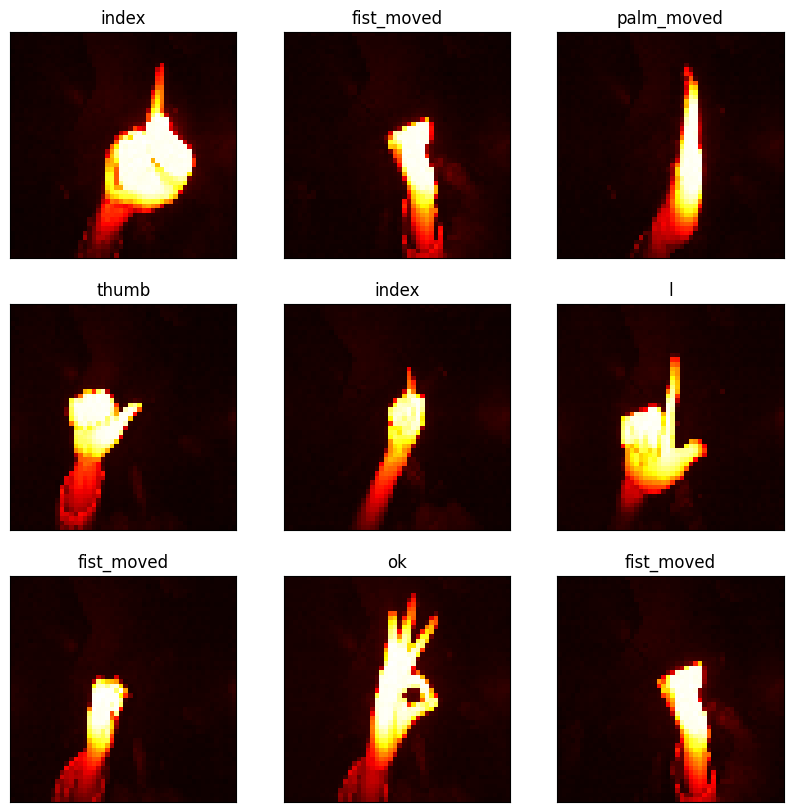

In [28]:
#@title shuffle & plot data
import random
random.shuffle(image_data)
input_data = []
label = []
for X, y in image_data:
    input_data.append(X)
    label.append(y)

plt.figure(1, figsize=(10,10))
for i in range(1,10):
    plt.subplot(3,3,i)
    plt.imshow(image_data[i][0], cmap='hot')
    plt.xticks([])
    plt.yticks([])
    plt.title(CATEGORIES[label[i]][3:])
plt.show()

In [29]:
# Normalization
input_data = np.array(input_data)
label = np.array(label)
input_data = input_data/255.0
input_data.shape

(20000, 50, 50)

In [30]:
label = keras.utils.to_categorical(label, num_classes=10,dtype='i1')
label[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=int8)

In [31]:
#@title reshape
input_data.shape = (-1, IMG_SIZE, IMG_SIZE, 1)

In [34]:
#@title splitting into training & testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_data, label, test_size = 0.3, random_state=0)

In [35]:
#@title Building The model
model = keras.models.Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape = (IMG_SIZE, IMG_SIZE, 1)))
model.add(Activation('relu'))


model.add(Conv2D(filters = 32, kernel_size = (3,3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 64, kernel_size = (3,3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer = 'rmsprop',
             metrics = ['accuracy'])

In [39]:
history = model.fit(X_train, y_train, epochs = 7, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/7
438/438 [==============================] - 142s 324ms/step - loss: 0.0024 - accuracy: 0.9992 - val_loss: 3.0895e-04 - val_accuracy: 1.0000
Epoch 2/7
438/438 [==============================] - 125s 285ms/step - loss: 0.0037 - accuracy: 0.9989 - val_loss: 2.4960e-04 - val_accuracy: 1.0000
Epoch 3/7
438/438 [==============================] - 132s 302ms/step - loss: 1.4798e-05 - accuracy: 1.0000 - val_loss: 5.5529e-05 - val_accuracy: 1.0000
Epoch 4/7
438/438 [==============================] - 125s 285ms/step - loss: 0.0015 - accuracy: 0.9994 - val_loss: 2.0319e-04 - val_accuracy: 1.0000
Epoch 5/7
438/438 [==============================] - 129s 296ms/step - loss: 1.6047e-04 - accuracy: 1.0000 - val_loss: 2.6884e-04 - val_accuracy: 0.9997
Epoch 6/7
438/438 [==============================] - 137s 313ms/step - loss: 4.9368e-04 - accuracy: 0.9999 - val_loss: 8.5435e-05 - val_accuracy: 1.0000
Epoch 7/7
438/438 [==============================] - 125s 285ms/step - loss: 3.5496e-04 - accu

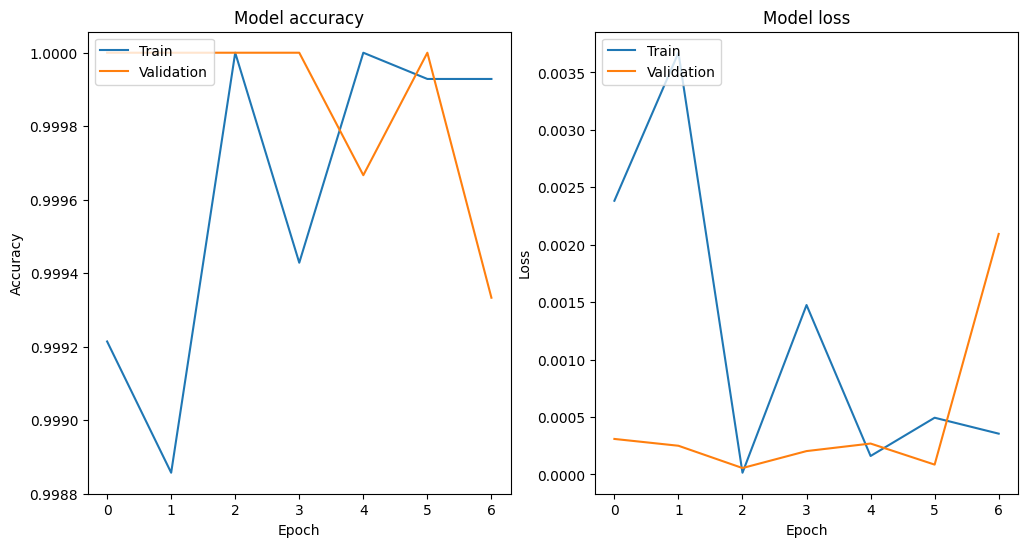

In [40]:
#@title Training History Plot

def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

# Call the function to plot the training history
plot_training_history(history)


In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 46, 46, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 23, 23, 32)        0         
                                                        

188/188 [==============================] - 12s 64ms/step


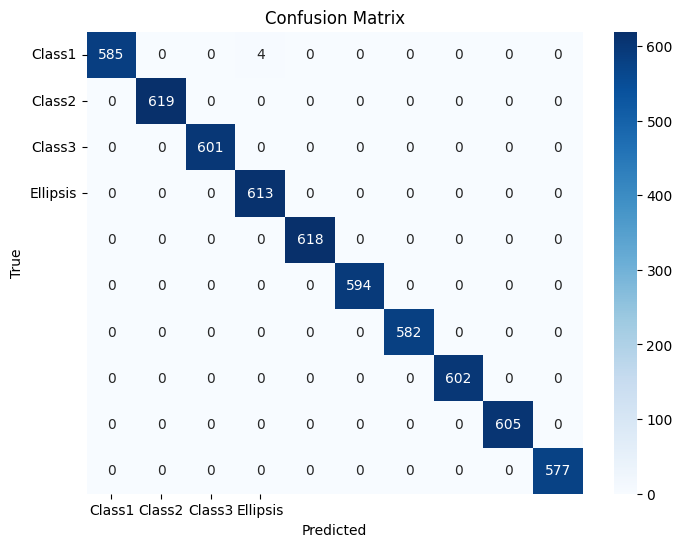

In [41]:
#@title confusion matrix
y_pred = model.predict(X_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred_classes, classes):
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Call the function to plot the confusion matrix
plot_confusion_matrix(y_true, y_pred_classes, classes=["Class1", "Class2", "Class3", ...])


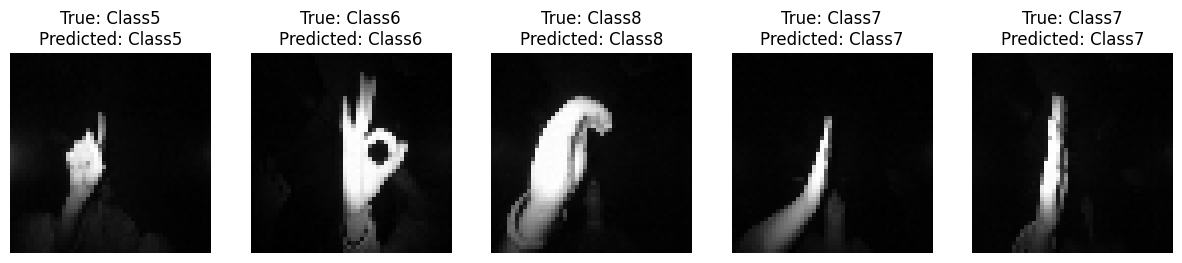

In [43]:
# Get unique class labels
unique_labels = np.unique(np.argmax(y_test, axis=1))

# Create classes list
classes = [f"Class{label}" for label in unique_labels]

# Define the function to plot sample predictions
def plot_sample_predictions(images, true_labels, pred_labels, classes):
    plt.figure(figsize=(15, 6))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
        plt.title(f'True: {classes[true_labels[i]]}\nPredicted: {classes[pred_labels[i]]}')
        plt.axis('off')
    plt.show()

# Call the function to plot sample predictions
plot_sample_predictions(sample_images, sample_labels, sample_predictions_classes, classes=classes)
